# Chap06 - 게이트가 추가된 RNN

> [Chap05-순환신경망(RNN)](https://github.com/ExcelsiorCJH/DLFromScratch2/blob/master/Chap05-Recurrent_Neural_Network/notebook.ipynb)에서 살펴본 RNN 구조는 순환경로를 통해 과거의 정보를 기억할 수 있었다. 하지만, 실제로는 성능이 좋지 못한데 그 이유는 장기(long term)의존 관계를 잘 학습할 수 없기 때문이다.  이번 장에서는 이러한 RNN의 단점을 보완한 LSTM, GRU에 대해서 다룬다. LSTM이나 GRU에는 **'게이트'**(gate)라는 구조가 더해져 있는데, 이 게이트 덕분에 시계열 데이터의 장기 의존 관계를 학습할 수 있다.

## 6.1 RNN의 문제점

- RNN의 문제점은 시계열 데이터의 장기 으존 관계(long-term dependency)를 학습하기 어렵다.

- 그 원인은 BPTT에서 기울기 소실 또는 기울기 폭발(vanishing & exploding gradient)이 일어나기 때문이다.

### 6.1.1 RNN 복습

<img src="./images/fig_6-1.png" height="70%" width="70%" />

- RNN 계층은 시계열 데이터인 $\mathbf{x}_{t}$를 입력하면 $\mathbf{h}_{t}$를 출력한다. 

- $\mathbf{h}_{t}$는 RNN 계층의 **은닉 상태(hidden state)**라고 하며, 과거 정보를 저장하는 역할을 한다.

- RNN cell의 내부를 자세히 살펴보면 아래의 그림과 같다.

<img src="./images/fig_6-2.png" height="50%" width="50%" />

### 6.1.2 기울기 소실 또는 기울기 폭발

<img src="./images/fig_6-3.png" height="70%" width="70%" />

- 위의 예시에서 `"?"`에 들어가는 단어는 "Tom"이다. 

- RNNLM이 이 문제에 올바르게 답하려면, "Tom was watching TV in his room."과  "Mary came into the room."이라는 정보를 기억해둬야 한다.

- 즉, 이러한 정보를 RNN 레이어의 hidden state에 인코딩해 보관해둬야 한다.

- 위의 예시에 대한 RNNLM의 BPTT는 아래의 그림과 같다.

<img src="./images/fig_6-4.png" height="60%" width="60%" />

- 위의 그림에서 RNN 레이어가 과거 방향으로 기울기(gradient)를 전달함으로써 시간 방향의 의존관계를 학습할 수 있게 된다.

- 이때의 기울기는 (이론적으로) 학습해야 할 정보가 들어 있고, 그것을 과거로 전달함으로써 장기 의존 관계를 학습한다.

- 하지만, 단순한 RNN(vanilla RNN) 레이어에서는 시간을 거슬러 올라갈수록 기울기가 작아지거나 커지는 문제가 발생한다(vanishing or exploding gradient).

### 6.1.3 기울기 소실과 기울기 폭발의 원인

<img src="./images/fig_6-5.png" height="70%" width="70%" />

- 위의 그림은 길이가 $T$인 시계열 데이터를 가정하여 $T$번째 정답 레이블로부터 전해지는 기울기가 어떻게 변화하는지 나타낸 그림이다.

- 이때, 시간 방향 기울기(gradient)를 살펴보면, 역전파로 전해지는 기울기는 차례로 `'tanh'` → `'+'` → `'MatMul'` 연산을 통과한다. 

- `'+'`의 역전파는 상류에서 전해지는 기울기를 그대로 하류로 흘려보내기 때문에 기울기의 값이 변하지 않지만, `'tanh'`와 `'MatMul'`은 변하게 된다.

#### tanh의 역전파

$$
y = \tanh{(x)} = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
$$

$$
\begin{align*}
\frac{\partial \tanh{(x)}}{\partial x} &= \frac{( e^x + e^{-x})(e^x + e^{-x}) - ( e^x - e^{-x})( e^x - e^{-x})}{( e^x + e^{-x})^{2}} \\ 
&= 1 - \frac{( e^x - e^{-x})( e^x - e^{-x})}{( e^x + e^{-x})^{2}} \\ 
&= 1 - \left\{ \frac{( e^x - e^{-x})}{( e^x + e^{-x})} \right\}^{2} \\
&= 1 - \tanh{(x)}^{2} \\
&= 1-y^{2}
\end{align*}
$$

<img src="./images/fig_6-6.png" height="40%" width="40%" />

- 위의 그래프에서 점선이 $y=\tanh{(x)}$의 미분이며, 그 값이 1.0 이하이고, $x$가 0으로 부터 멀어질수록 작아진다. 

- 따라서, 역전파에서 기울기가 $\tanh$ 노드를 지날때 마다 값은 계속해서 작아지게 된다. 

#### MatMul에서의 역전파

<img src="./images/fig_6-7.png" height="70%" width="70%" />

- 상류로부터 흘러온 기울기 $\mathbf{dh}$ `'MatMul'`노드에서의 역전파는 $\mathbf{dh} \cdot \mathbf{W_h}^{\mathsf{T}}$라는 행렬 곱이 된다.

- 이러한 행렬곱이 시계열 데이터의 time_step 만큼 반복한다. 

[1.32971447 0.30503349 0.08888152]


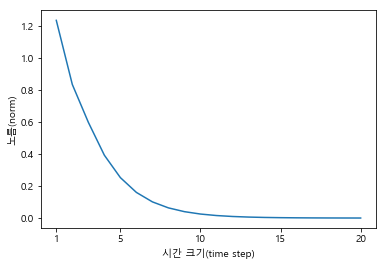

In [2]:
# chap06/rnn_gradient_graph.py
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)


N = 2  # 미니배치 크기
H = 3  # hidden state 벡터의 차원 수
T = 20  # 시계열 데이터의 길이(= timestep)

dh = np.ones((N, H))
np.random.seed(3)
# Wh = np.random.randn(H, H) 
Wh = np.random.randn(H, H) * 0.5 

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)
    
u, s, vh = np.linalg.svd(Wh)
print(s)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('시간 크기(time step)')
plt.ylabel('노름(norm)')
plt.show()

### 6.1.4 기울기 폭발 대책

- 기울기 폭발(exploding gradient) 해결책으로는 **기울기 클리핑(gradients clipping)**이라는 기법이 있다.

- 기울기 클리핑 알고리즘을 의사코드로 나타내면 다음과 같다.

$$
\text{if } \left\| \hat{g} \right\| \ge threshold:
$$

$$
\hat{g} = \frac{threshold}{\left\| \hat{g} \right\|} \hat{g}
$$

- 위의 식에서 $\hat{g}$는 신경망에서 사용되는 모든 매개변수의 기울기를 하나로 모은 것이다.
    - 예를 들어, $\mathbf{W}_{1}$과 $\mathbf{W}_{2}$ 매개변수에 대한 기울기 $\mathbf{dW}_{1}$과 $\mathbf{dW}_{2}$를 결합(제곱의 합)한 것이다.
    

- 위의 식에서 $\left\| \hat{g} \right\|$(기울기 L2 노름)가 $threshold$ 값을 초과하면 두 번째 수식과 같이 기울기를 수정한다. 

In [5]:
# chap06/clip_grads.py
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0  # threshold

def clip_grads(grds, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

In [6]:
print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())

before: [2.77977507 4.54622076 2.05410345 2.01378711 5.1403506  0.87229369
 4.83585532 3.62176212 7.07686622]
after: [0.66651711 1.09006443 0.4925201  0.4828533  1.23252117 0.20915313
 1.15951119 0.86840351 1.69684679]


## 6.2 기울기 소실과 LSTM

### 6.2.1 LSTM의 인터페이스

- 아래의 그림과 같이 $\tanh{\left( \mathbf{h}_{t-1} \mathbf{W}_{\mathbf{h}} + \mathbf{x}_{t} \mathbf{W}_{\mathbf{x}} + \mathbf{b} \right)}$ 를 `tanh`노드로 나타내어 간소화한 것이다.

<img src="./images/fig_6-10.png" height="70%" width="70%" />

- RNN Cell과 LSTM Cell을 간단하게 비교하면 아래의 그림처럼 나타낼 수 있다.

<img src="./images/fig_6-11.png" height="70%" width="70%" />

- 위의 그림에서 보듯 LSTM 계층에는 $\mathbf{c}$라는 경로가 있다는 것이 RNN과의 차이다. 

- $\mathbf{c}$를 **기억 셀**(memory cell)이라고 하며, LSTM의 기억 메커니즘이다.

- memory cell의 특징은 LSTM 계층 내에서만 주고받는다는 것이다.
    - 다른 계층으로는 출력하지 않는다. 

### 6.2.2 LSTM 계층 조립하기

- $\mathbf{c}_{t}$에는 timestep $t$에서의 LSTM의 기억이 저장되어 있는데, 과거로 부터 $t$까지에 필요한 모든 정보가 저장되어 있다고 가정한다.

- 이러한 기억 $\mathbf{c}_{t}$를 바탕으로 특정 연산을 거친 후 외부 계층과 다음 timestep $t+1$의 LSTM에 hidden state $\mathbf{h}_{t}$를 출력한다. 
     - 이때 출력하는 $\mathbf{h}_{t}$는 아래의 그림처럼 memory cell $\mathbf{c}_{t}$의 값을 $\tanh$ 함수로 변환한 값이다.

<img src="./images/fig_6-12.png" height="60%" width="60%" />

- memory cell $\mathbf{c}_{t}$와 hidden state $\mathbf{h}_{t}$의 관계는 $\mathbf{c}_{t}$의 각 원소에 $\tanh$ 함수를 적용한 것이다. 

- 즉, $\mathbf{c}_{t}$와 $\mathbf{h}_{t}$의 원소수는 같다는 뜻이고, 예를 들어, $\mathbf{c}_{t}$의 원소 수가 100개면 $\mathbf{h}_{t}$의 원소 수도 100개가 된다.

#### 게이트(gate)의 개념

- 게이트는 **데이터의 흐름**을 **제어(control)**하는 역할을 한다.

- 아래의 그림처럼 게이트의 열림 상태는 `0.0 ~ 1.0` 사이의 실수로 나타나며, '게이트를 얼마나 열까'라는 것도 데이터로 부터 (자동으로) 학습 한다.

- 게이트의 열림 상태를 구할 때는 `sigmoid` 함수를 사용하는데, `sigmoid`함수의 출력이 0.0 ~ 1.0의 실수이기 떄문이다.

<img src="./images/fig_6-14.png" height="60%" width="60%" />

#### LSTM의 게이트들

<img src="./images/lstm.PNG" height="80%" width="80%" />

### 6.2.3 output 게이트


- output 게이트는 hidde state($\mathbf{h}_{t}$)의 출력을 담당한다.

- output 게이트는 $\tanh{(\mathbf{c}_{t})}$의 각 원소에 대해 '그것이 다음 timestep의 hidde state($\mathbf{h}_{t}$)에 얼마나 중요한가'를 제어한다.

- output 게이트의 열림 상태는 입력 $\mathbf{x}_{t}$와 이전 상태 $\mathbf{h}_{t-1}$로 부터 구한다. 아래의 식에서 $\sigma {()}$는 시그모이드 함수를 의미한다.


$$
\mathbf{o} = \sigma \left( \mathbf{x}_{t}\mathbf{W}_{\mathbf{x}}^{(o)} + \mathbf{h}_{t-1} \mathbf{W}_{\mathbf{h}}^{(o)} + \mathbf{b}^{(o)} \right)
$$

<img src="./images/fig_6-15.png" height="60%" width="60%" />

- 위의 그림에서 output 게이트의 열림 상태를 계산한 $\mathbf{o}$는 $\tanh{\mathbf{c}_{t}}$의 원소별 곱(element-wise, point-wise, 또는 아다마르 곱)을 통해 $\mathbf{h}_{t}$를 구하게 된다.

$$
\mathbf{h}_{t} = \mathbf{o} \odot \tanh{(\mathbf{c}_{t})}
$$

> - $\tanh$의 출력은 `-1.0 ~ 1.0`의 실수이다. 이 `-1.0 ~ 1.0`의 수치를 그 안에 인코딩된 **'정보'**의 강약(정도)를 표시한다고 해석할 수 있다.
- 시그모이드 함수의 출력은 `0.0 ~ 1.0`의 실수이며, 데이터를 얼만큼 통과시킬지를 정하는 비율을 뜻한다.
- 따라서, 게이트에서는 시그모이드 함수가 사용되고, 실질적인 '정보'를 지니는 데이터에는 $\tanh$함수가 사용된다.